# Construcción de Técnicas de Normalización para Datos en Histograma time residual  vs cos(α)

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn

# 1 - Extraer datos

In [2]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/High Statistic/simu_Analysis_elec_5MeV.root")
file.keys()

['T;64', 'T;63', 'pmt;2', 'pmt;1']

In [3]:
data1 = file['T;64']
pmt_info = file['pmt;1']

## 1.1 - EV info

In [4]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
#mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.2 - PMT info

In [5]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Extract Valid Data

In [6]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([        0,         1,         2, ..., 139457001, 139457002,
       139457003], dtype=int64)

## 2.1 - Extraer información valida de PMT info

In [7]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

### 2.1.1 - Usar info. de PMTs para contabilizar el Nº de PMTs dentro de un subsección relacionada con el cos(α) - Dirección de evento

- 1ero. Calcular cos(α) para todos los PMTs
- 2ero. Dividir α en subsecciones (corresponder al binning del histograma). Usaremos el cos(α). α varia entre [0,π], y cos(α) entre [-1,1]
- 3do. Contabilizar el nº de PMTs dentro de está sección y guardar esta información -> Nº de PMTs = Nº de datos en cos(Δα)


## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [8]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 10
#time cut
inf_cut = -5
up_cut = 15

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------

# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
#multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    #multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        #multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    #multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        #multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
#multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
computing cos(alpha)
doing time residual cuts
slipt nº: 5
computing cos(alpha)
doing time residual cuts
slipt nº: 6
computing cos(alpha)
doing time residual cuts
slipt nº: 7
computing cos(alpha)
doing time residual cuts
slipt nº: 8
computing cos(alpha)
doing time residual cuts
slipt nº: 9
computing cos(alpha)
doing time residual cuts


# 3 - Histograma 2D: time residual vs. cos(α)

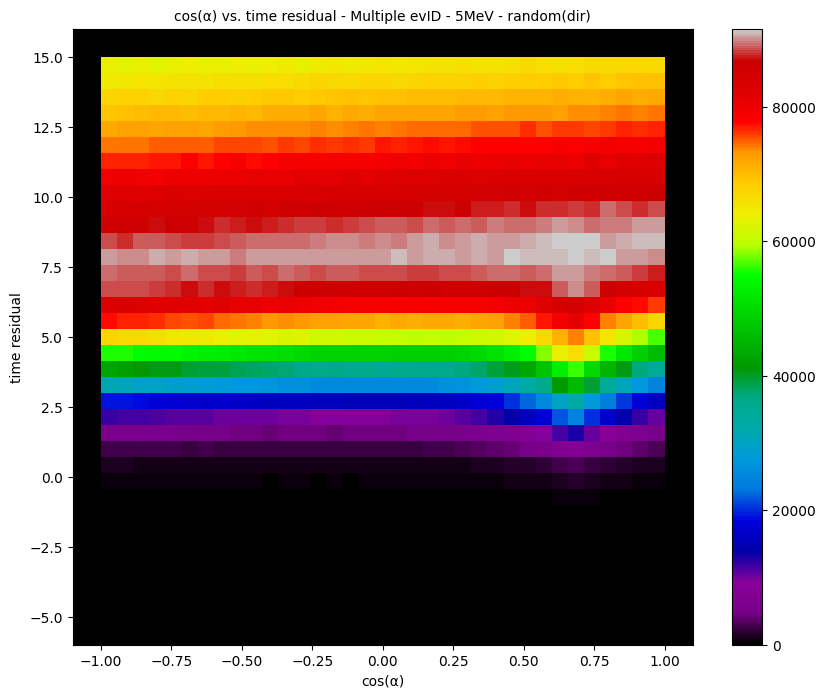

In [10]:
#%matplotlib
# 2d Histogram
bins = 35
#Titles

if radi_cut_method == True:
    title = 'cos(α) vs. Time Residual Multiple evID - 5MeV - random(dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'cos(α) vs. time residual - Multiple evID - 5MeV - random(dir)'
    
ylabel = 'time residual'
xlabel = 'cos(α)'

plt.figure(figsize=(10,8))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins], stat='count', cbar = 'True', cmap = cm.nipy_spectral, hue_norm = (0,1))
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize= 10)

#plt.savefig('figs/High Stat/'+ title + '.png', format = 'png')
plt.show()

# 4 - Construcción Histogramas Normalizados 

## 4.1 - Extraer Información a Normalizar

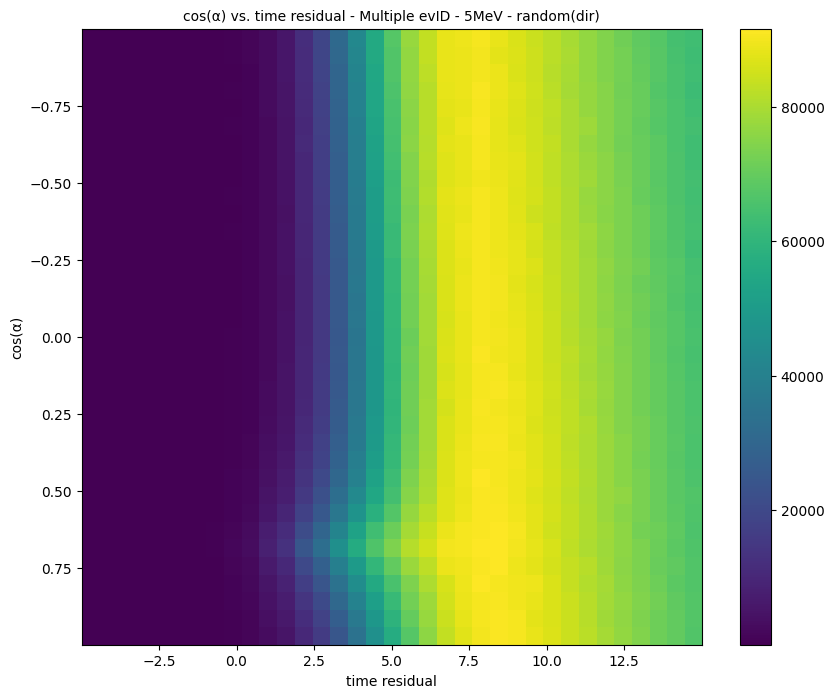

In [11]:
#Transforma Data into an Image Matrix
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

N_ylabel = 'cos(α)'
N_xlabel = 'time residual'

plt.figure(figsize=(10,8))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(N_ylabel)
plt.xlabel(N_xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/'+ title + '(imshow).png', format = 'png')

### 4.1.1 - Metodo 2: Dividir por el Nº de PMTs disponibles en cada bin de cos(α)

### 4.1.2 - Metodo 1: Dividir por el Nº de PMTs que dan hit en cada bin de cos(α)

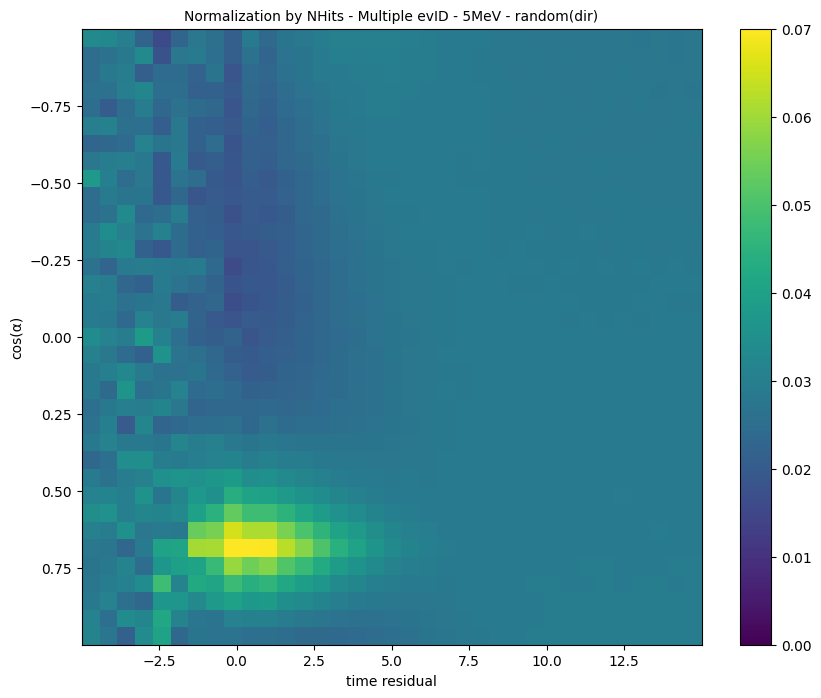

In [12]:
# sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_normalized1 = H / sum_hit

if radi_cut_method == True:
    N2title = 'Normalization by NHits - Multiple evID - 5MeV - random(dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    N2title = 'Normalization by NHits - Multiple evID - 5MeV - random(dir)'

plt.figure(figsize=(10,8))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto", vmin = 0.0, vmax = 0.07)
plt.title(N2title, fontsize= 10)
plt.ylabel(N_ylabel)
plt.xlabel(N_xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/'+ N2title +'.png', format = 'png')
plt.show()


In [18]:
plt.imshow(H_normalized1)